In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, mean_absolute_percentage_error, explained_variance_score, max_error
pd.set_option('display.max_columns', None)
from IPython.display import display
import lightgbm as lgb
import numpy as np
import optuna


data = pd.read_csv("./preprocessed_data.csv")
data.drop_duplicates(subset="link")

Unnamed: 0                                              title  \
0              0  apartamento t0 rua eleuterio teixeira 8 capari...   
1              1    apartamento t0 sao joao caparica costa caparica   
2              2    apartamento t0 sao joao caparica costa caparica   
3              3  apartamento t0 avenida liberdade 5 caparica tr...   
4              4                              apartamento t1 almada   
...          ...                                                ...   
7322        7322  apartamento t3 rua senhora graca repeses sao s...   
7323        7323  apartamento t3 avenida doutor antonio jose alm...   
7324        7324  apartamento t3 avenida belgica 42 aguieira   s...   
7325        7325  apartamento t3 rua antonio gois guerreiro 185 ...   
7326        7326  andar moradia rua fontelo 108 gumiraes   carre...   

        home_type                                       link garage  price  \
0     apartamento  https://www.idealista.pt/imovel/33394837/     No   1000   
1     apartamento  https://www.idealista.pt/imovel/33182313/     No   1250   
2     apartamento  https://www.idealista.pt/imovel/33225472/     No   1200   
3     apartamento  https://www.idealista.pt/imovel/33132721/     No   1200   
4     apartamento  https://www.idealista.pt/imovel/33394381/     No    918   
...           ...                                        ...    ...    ...   
7322  apartamento  https://www.idealista.pt/imovel/33389978/     No    750   
7323  apartamento  https://www.idealista.pt/imovel/30425307/     No    880   
7324  apartamento  https://www.idealista.pt/imovel/33355326/     No    700   
7325  apartamento  https://www.idealista.pt/imovel/33358685/     No   1200   
7326        andar  https://www.idealista.pt/imovel/33268792/    Yes   1000   

                                            description home_size  home_area  \
0     Estúdio com muita luz, casa de banho com duche...        T0         50   
1     Apartamento T0, com vista de Mar.\nNão perca a...        T0         60   
2     Não perca a oportunidade de viver num apartame...        T0         57   
3     Excelente apartamento t1 na Trafaria, a 2 minu...        T0         50   
4     Apartamento de tipologia T1 em prédio totalmen...        T1         55   
...                                                 ...       ...        ...   
7322  Apartamento com 3 quartos com moveis\nCozinha ...        T3        110   
7323  Apartamento no centro de Viseu no último andar...        T3        140   
7324                                                NaN        T3         86   
7325                                                NaN        T3        100   
7326                                                NaN        T4        125   

      floor  elevator  price_per_sqr_meter    city     source  \
0       0.0     False            20.000000  Almada  idealista   
1      10.0      True            20.833333  Almada  idealista   
2       6.0      True            21.052632  Almada  idealista   
3       1.0     False            24.000000  Almada  idealista   
4       0.0     False            16.690909  Almada  idealista   
...     ...       ...                  ...     ...        ...   
7322    2.0     False             6.818182   Viseu  idealista   
7323    4.0      True             6.285714   Viseu  idealista   
7324    1.0     False             8.139535   Viseu  idealista   
7325    5.0      True            12.000000   Viseu  idealista   
7326    0.0     False             8.000000   Viseu  idealista   

               neighborhood price_per_sqr_meter_bin         price_bin  \
0                    almada        (18.686, 23.248]  (355.38, 1364.8]   
1            costa caparica        (18.686, 23.248]  (355.38, 1364.8]   
2            costa caparica        (18.686, 23.248]  (355.38, 1364.8]   
3                    almada         (23.248, 27.81]  (355.38, 1364.8]   
4     apartamento t1 almada        (14.124, 18.686]  (355.38, 1364.8]   
...                     ...         

In [2]:
selected_features = ["home_type", "garage", "home_size", "floor", "elevator", "city", "neighborhood", "home_area", "street_names"]
target = ["price"]

data = data[selected_features + target]

In [3]:
for c in data.columns:
    col_type = data[c].dtype
    if col_type == 'object' or col_type == 'bool':
        data[c] = data[c].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7327 entries, 0 to 7326
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   home_type     7325 non-null   category
 1   garage        7327 non-null   category
 2   home_size     7327 non-null   category
 3   floor         7327 non-null   float64 
 4   elevator      7327 non-null   category
 5   city          7327 non-null   category
 6   neighborhood  7327 non-null   category
 7   home_area     7327 non-null   int64   
 8   street_names  7327 non-null   category
 9   price         7327 non-null   int64   
dtypes: category(7), float64(1), int64(2)
memory usage: 254.2 KB


In [4]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=target), 
                                                    data[target], 
                                                    test_size=0.2, 
                                                    random_state=42)

In [5]:
d_train = lgb.Dataset(X_train, label=y_train)
d_valid = lgb.Dataset(X_test, label=y_test)

from optuna.integration import LightGBMTuner
optuna.logging.set_verbosity(0)

def tune_hyperparameters(d_train, d_valid):
    params = {
        'objective': 'tweedie',  # or 'tweedie' or any other suitable according to your task
        'metric': 'rmse',           # Evaluation metric
        'boosting_type': 'gbdt',    # Default boosting type
    }

    # Creating the tuner
    tuner = LightGBMTuner(params, 
                          d_train,
                          valid_sets=[d_valid],
                          num_boost_round=1000,
                          show_progress_bar = True)  # Maximum number of boosting iterations

    # Running the tuning
    tuner.run()

    print("Best score:", tuner.best_score)
    best_params = tuner.best_params
    print("Best params:", best_params)
    best_booster = tuner.get_best_booster()

    return best_params, best_booster

best_params, best_booster = tune_hyperparameters(d_train, d_valid)


feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730


feature_fraction, val_score: 803.112705:  14%|#4        | 1/7 [00:04<00:25,  4.21s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730


feature_fraction, val_score: 803.112705:  29%|##8       | 2/7 [00:08<00:19,  3.99s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730


feature_fraction, val_score: 793.865334:  43%|####2     | 3/7 [00:11<00:15,  3.89s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730


feature_fraction, val_score: 793.865334:  57%|#####7    | 4/7 [00:15<00:11,  3.75s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730


feature_fraction, val_score: 793.865334:  71%|#######1  | 5/7 [00:18<00:07,  3.57s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730


feature_fraction, val_score: 793.865334:  86%|########5 | 6/7 [00:22<00:03,  3.62s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000784 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730


num_leaves, val_score: 793.865334:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

num_leaves, val_score: 779.788175:   5%|5         | 1/20 [00:16<05:13, 16.51s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

num_leaves, val_score: 779.788175:  10%|#         | 2/20 [00:27<04:00, 13.35s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

num_leaves, val_score: 779.788175:  15%|#5        | 3/20 [00:41<03:53, 13.74s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730


num_leaves, val_score: 779.788175:  20%|##        | 4/20 [00:44<02:29,  9.37s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

num_leaves, val_score: 779.788175:  25%|##5       | 5/20 [00:56<02:36, 10.41s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

num_leaves, val_score: 779.788175:  30%|###       | 6/20 [01:12<02:49, 12.12s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

num_leaves, val_score: 779.788175:  35%|###5      | 7/20 [01:23<02:34, 11.88s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

num_leaves, val_score: 779.788175:  40%|####      | 8/20 [01:36<02:26, 12.24s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

num_leaves, val_score: 779.788175:  45%|####5     | 9/20 [01:45<02:02, 11.18s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

num_leaves, val_score: 779.788175:  50%|#####     | 10/20 [01:57<01:54, 11.47s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

num_leaves, val_score: 779.788175:  55%|#####5    | 11/20 [02:10<01:46, 11.83s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

num_leaves, val_score: 779.788175:  60%|######    | 12/20 [02:23<01:37, 12.21s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

num_leaves, val_score: 779.788175:  65%|######5   | 13/20 [02:34<01:23, 11.94s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

num_leaves, val_score: 779.788175:  70%|#######   | 14/20 [02:42<01:05, 10.86s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

num_leaves, val_score: 779.788175:  75%|#######5  | 15/20 [02:56<00:57, 11.54s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

num_leaves, val_score: 779.788175:  80%|########  | 16/20 [03:11<00:50, 12.70s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

num_leaves, val_score: 779.788175:  85%|########5 | 17/20 [03:25<00:39, 13.24s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

num_leaves, val_score: 779.788175:  90%|######### | 18/20 [03:38<00:25, 12.92s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

num_leaves, val_score: 779.788175:  95%|#########5| 19/20 [03:51<00:13, 13.03s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

bagging, val_score: 779.788175:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

bagging, val_score: 779.788175:  10%|#         | 1/10 [00:08<01:13,  8.12s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

bagging, val_score: 779.788175:  20%|##        | 2/10 [00:23<01:37, 12.15s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

bagging, val_score: 779.788175:  30%|###       | 3/10 [00:31<01:12, 10.42s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

bagging, val_score: 779.206258:  40%|####      | 4/10 [00:45<01:10, 11.74s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

bagging, val_score: 779.206258:  50%|#####     | 5/10 [01:06<01:16, 15.27s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

bagging, val_score: 779.206258:  60%|######    | 6/10 [01:21<01:00, 15.16s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

bagging, val_score: 779.206258:  70%|#######   | 7/10 [01:34<00:43, 14.46s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

bagging, val_score: 779.206258:  80%|########  | 8/10 [01:52<00:30, 15.39s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

bagging, val_score: 779.206258:  90%|######### | 9/10 [02:04<00:14, 14.34s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

feature_fraction_stage2, val_score: 779.206258:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

feature_fraction_stage2, val_score: 779.206258:  33%|###3      | 1/3 [00:12<00:25, 12.67s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

feature_fraction_stage2, val_score: 779.206258:  67%|######6   | 2/3 [00:29<00:14, 14.88s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

regularization_factors, val_score: 779.206258:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

regularization_factors, val_score: 778.725804:   5%|5         | 1/20 [00:14<04:27, 14.10s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

regularization_factors, val_score: 778.725804:  10%|#         | 2/20 [00:31<04:52, 16.24s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

regularization_factors, val_score: 778.725804:  15%|#5        | 3/20 [00:52<05:07, 18.08s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

regularization_factors, val_score: 778.725804:  20%|##        | 4/20 [01:07<04:29, 16.87s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

regularization_factors, val_score: 778.625422:  25%|##5       | 5/20 [01:23<04:11, 16.74s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

regularization_factors, val_score: 778.625422:  30%|###       | 6/20 [01:36<03:38, 15.58s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

regularization_factors, val_score: 778.625422:  35%|###5      | 7/20 [01:50<03:12, 14.80s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

regularization_factors, val_score: 778.625422:  40%|####      | 8/20 [02:05<03:01, 15.11s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

regularization_factors, val_score: 777.658097:  45%|####5     | 9/20 [02:22<02:51, 15.55s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

regularization_factors, val_score: 777.658097:  50%|#####     | 10/20 [02:36<02:29, 14.95s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

regularization_factors, val_score: 777.658097:  55%|#####5    | 11/20 [02:56<02:29, 16.62s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

regularization_factors, val_score: 777.658097:  60%|######    | 12/20 [03:11<02:09, 16.23s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

regularization_factors, val_score: 777.658097:  65%|######5   | 13/20 [03:24<01:46, 15.17s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

regularization_factors, val_score: 777.658097:  70%|#######   | 14/20 [03:39<01:30, 15.15s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

regularization_factors, val_score: 777.658097:  75%|#######5  | 15/20 [04:01<01:26, 17.27s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

regularization_factors, val_score: 777.658097:  80%|########  | 16/20 [04:19<01:09, 17.37s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

regularization_factors, val_score: 777.658097:  85%|########5 | 17/20 [04:33<00:49, 16.47s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

regularization_factors, val_score: 777.658097:  90%|######### | 18/20 [04:51<00:33, 16.70s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

regularization_factors, val_score: 777.658097:  95%|#########5| 19/20 [05:04<00:15, 15.69s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

min_child_samples, val_score: 777.658097:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

min_child_samples, val_score: 777.658097:  20%|##        | 1/5 [00:10<00:43, 10.89s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

min_child_samples, val_score: 777.658097:  40%|####      | 2/5 [00:19<00:29,  9.68s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

min_child_samples, val_score: 777.658097:  60%|######    | 3/5 [00:47<00:36, 18.04s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

min_child_samples, val_score: 777.658097:  80%|########  | 4/5 [01:06<00:18, 18.45s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

min_child_samples, val_score: 777.658097: 100%|##########| 5/5 [01:12<00:00, 14.57s/it]

Best score: 777.6580970483313
Best params: {'objective': 'tweedie', 'metric': 'rmse', 'boosting_type': 'gbdt', 'feature_pre_filter': False, 'lambda_l1': 0.008497463036493931, 'lambda_l2': 1.0693038532902205e-05, 'num_leaves': 201, 'feature_fraction': 0.4, 'bagging_fraction': 0.9892216721370148, 'bagging_freq': 7, 'min_child_samples': 20}


In [10]:
def regression_scores(y_test, y_pred):
    scores = {}
    scores['mean_squared_error'] = mean_squared_error(y_test, y_pred)
    scores['root_mean_squared_error'] = mean_squared_error(y_test, y_pred, squared=False)
    scores['mean_absolute_error'] = mean_absolute_error(y_test, y_pred)
    scores['median_absolute_error'] = median_absolute_error(y_test, y_pred)
    scores['r2_score'] = r2_score(y_test, y_pred)
    scores['mean_absolute_percentage_error'] = mean_absolute_percentage_error(y_test, y_pred)
    scores['explained_variance_score'] = explained_variance_score(y_test, y_pred)
    scores['max_error'] = max_error(y_test, y_pred)

    return scores


In [11]:
def train_and_evaluate(X_test, y_test, best_model):

    # Predicting the test set results
    y_pred = best_model.predict(X_test)

    # Evaluating the predictions
    scores = regression_scores(y_test, y_pred)
    return scores

NameError: name 'plt' is not defined

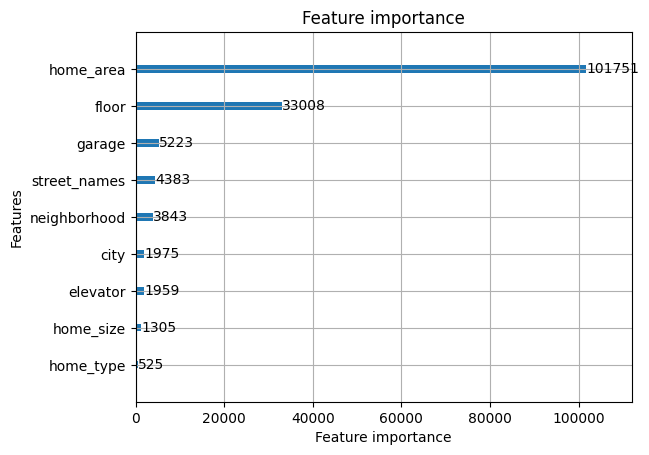

In [8]:
ax = lgb.plot_importance(best_booster, max_num_features=10)
plt.show()


# piecewise optimization 

In [12]:
scores = train_and_evaluate(X_test, y_test, best_booster)
display(scores)

c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'mean_squared_error': 604752.1159048319,
 'root_mean_squared_error': 777.6580970483313,
 'mean_absolute_error': 371.83376146174726,
 'median_absolute_error': 150.9659638289437,
 'r2_score': 0.8393410698632285,
 'mean_absolute_percentage_error': 0.1642133489328092,
 'explained_variance_score': 0.8395290574648101,
 'max_error': 8015.6627059216735}